2025-09-06 11:12:07.609329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 11:12:07.614900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 11:12:07.801674: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 11:12:07.865142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757175128.011442     405 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757175128.05

Reloading Tuner from hyperparam_tuning/meat_classification/tuner0.json


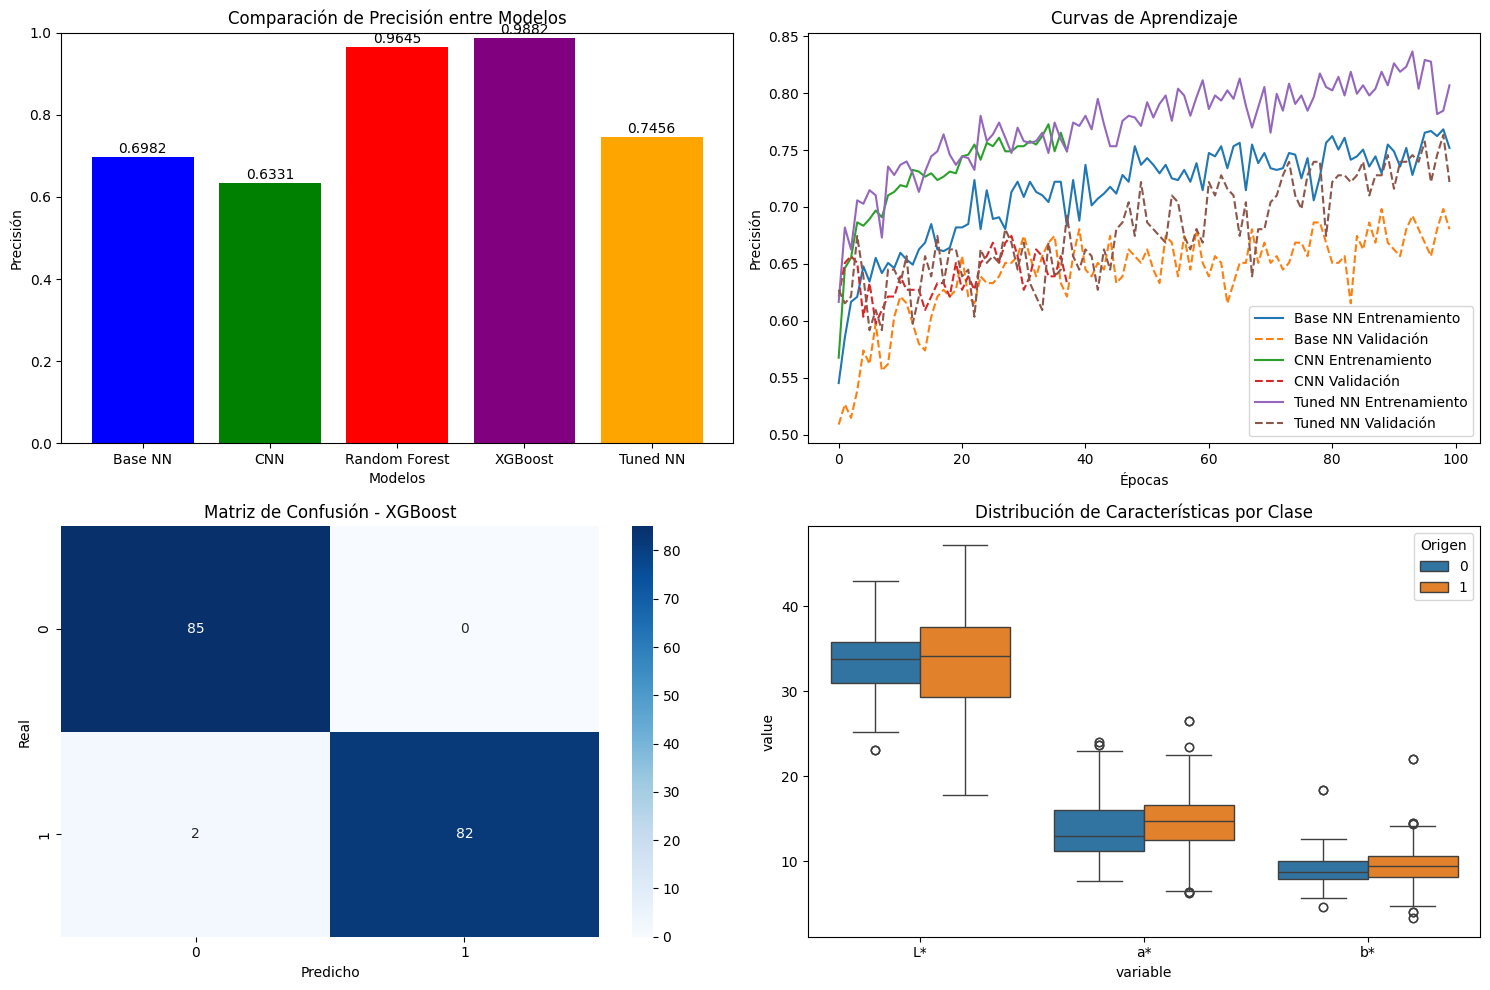

Precisión de los modelos:
Base NN: 0.6982
CNN: 0.6331
Random Forest: 0.9645
XGBoost: 0.9882
Tuned NN: 0.7456

Mejor modelo: XGBoost con precisión 0.9882


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
data = pd.read_excel('archivo_combinado.xlsx')

# Preprocesamiento
X = data[['L*', 'a*', 'b*']].values
y = LabelEncoder().fit_transform(data['Origen'])  # 0: alpaca, 1: Llama

# División y escalado de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Modelo Base Mejorado
def create_base_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(3,), kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2. Modelo CNN para características de color
def create_cnn_model():
    model = keras.Sequential([
        layers.Reshape((3, 1), input_shape=(3,)),
        layers.Conv1D(32, 2, activation='relu'),
        layers.MaxPooling1D(1),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Optimización de Hiperparámetros con Keras Tuner
def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), 
                           activation='relu', input_shape=(3,)))
    model.add(layers.Dropout(rate=hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=128, step=32),
                               activation='relu'))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i+2}', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='hyperparam_tuning',
                     project_name='meat_classification')

# 4. Random Forest y XGBoost
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# Entrenamiento y Evaluación
def train_and_evaluate_models():
    models = {
        'Base NN': create_base_model(),
        'CNN': create_cnn_model(),
        'Random Forest': rf_model,
        'XGBoost': xgb_model
    }
    
    history_dict = {}
    results = {}
    
    # Entrenar modelos de sklearn
    for name, model in models.items():
        if name in ['Random Forest', 'XGBoost']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            results[name] = accuracy_score(y_test, y_pred)
        else:
            history = model.fit(X_train_scaled, y_train, 
                               validation_data=(X_test_scaled, y_test),
                               epochs=100, batch_size=16, verbose=0,
                               callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])
            history_dict[name] = history.history
            test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
            results[name] = test_acc
    
    # Optimización de hiperparámetros
    tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), verbose=0)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    best_history = best_model.fit(X_train_scaled, y_train, 
                                 validation_data=(X_test_scaled, y_test),
                                 epochs=100, batch_size=16, verbose=0,
                                 callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])
    history_dict['Tuned NN'] = best_history.history
    test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
    results['Tuned NN'] = test_acc
    
    return results, history_dict, models

# Ejecutar entrenamiento y evaluación
results, history_dict, models = train_and_evaluate_models()

# Visualizaciones
plt.figure(figsize=(15, 10))

# 1. Precisión de modelos
plt.subplot(2, 2, 1)
models_names = list(results.keys())
accuracies = list(results.values())
plt.bar(models_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Comparación de Precisión entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

# 2. Curvas de aprendizaje para redes neuronales
plt.subplot(2, 2, 2)
for model_name, history in history_dict.items():
    plt.plot(history['accuracy'], label=f'{model_name} Entrenamiento')
    plt.plot(history['val_accuracy'], label=f'{model_name} Validación', linestyle='--')
plt.title('Curvas de Aprendizaje')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# 3. Matriz de confusión para el mejor modelo
plt.subplot(2, 2, 3)
best_model_name = max(results, key=results.get)
if best_model_name in ['Random Forest', 'XGBoost']:
    best_model = models[best_model_name]
    y_pred = best_model.predict(X_test_scaled)
else:
    best_model = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
    best_model.fit(X_train_scaled, y_train, epochs=100, verbose=0)
    y_pred = (best_model.predict(X_test_scaled) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicho')
plt.ylabel('Real')

# 4. Distribución de características por clase
plt.subplot(2, 2, 4)
df_plot = pd.DataFrame(X_train, columns=['L*', 'a*', 'b*'])
df_plot['Origen'] = y_train
sns.boxplot(data=df_plot.melt(id_vars='Origen'), x='variable', y='value', hue='Origen')
plt.title('Distribución de Características por Clase')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300)
plt.show()

# Resultados detallados
print("Precisión de los modelos:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

# Mejor modelo
print(f"\nMejor modelo: {best_model_name} con precisión {results[best_model_name]:.4f}")

# Ejemplo de predicción
muestra_ejemplo = np.array([[33.86, 13.91, 9.12]])  # Valores medios de Llama
muestra_escalada = scaler.transform(muestra_ejemplo)
if best_model_name in ['Random Forest', 'XGBoost']:
    prediccion = best_model.predict(muestra_escalada)
    proba = best_model.predict_proba(muestra_escalada)[0]
else:
    prediccion = (best_model.predict(muestra_escalada) > 0.5).astype("int32")
    proba = best_model.predict(muestra_escalada)[0][0]
print(f'\nPredicción para muestra ejemplo: {prediccion[0]} (Probabilidad: {proba:.4f})')
print('(0: Alpaca, 1: Llama)')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import pickle

# Cargar datos
data = pd.read_excel('archivo_combinado.xlsx')

# Preprocesamiento
X = data[['L*', 'a*', 'b*']].values
y = LabelEncoder().fit_transform(data['Origen'])  # 0: alpaca, 1: Llama

# División y escalado de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# GUARDAR EL MODELO Y EL ESCALADOR
# 1. Guardar el modelo XGBoost
xgb_model.save_model('xgboost_model.json')  # Formato nativo de XGBoost (recomendado)

# 2. Guardar el escalador con pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModelo y escalador guardados exitosamente.")